# Continuous Evaluation and Retraining Exercise

## Objective
This exercise will guide you through implementing a continuous evaluation and retraining pipeline.

### Tools Used:
- Pandas: For data manipulation and analysis.
- NumPy: For numerical computations and array operations.
- MLflow: For managing the ML lifecycle.
- Scikit-learn: For ML model training and evaluation.
- Matplotlib: For data visualization and plotting.

### Step 0: Setup
Install and import the necessary libraries.

In [ ]:
# Install required libraries
!pip install mlflow

# Import libraries
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


### Step 1: Train a Simple Model and Log It Using MLFlow
Train a classification model on the Wine dataset.

In [ ]:
# Load dataset
data = load_wine()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MLFlow
mlflow.set_experiment("mlops_exercise")

# Train the model
with mlflow.start_run(run_name="Initial Training"):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Log model and metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(model, "model")

    print(f"Initial model logged with Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}")

2024/12/24 20:34:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Initial model logged with Accuracy: 1.00, F1-score: 1.00


### Step 2: Monitor Model Metrics Over Time
Define a function to monitor key metrics.

In [ ]:
def monitor_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}")
    return accuracy, f1

### Step 3: Simulate Data Drift and Evaluate Model Performance
Simulate drift by adding noise to the test data.

In [ ]:
def simulate_drift(X, drift_factor=0.5):
    drifted_X = X + np.random.normal(0, drift_factor, X.shape)
    return drifted_X

X_test_drifted = simulate_drift(X_test)
print("Metrics on drifted data:")
monitor_model(model, X_test_drifted, y_test)

Metrics on drifted data:
Accuracy: 0.97, F1-score: 0.97


(0.9722222222222222, 0.9717752234993614)

### Step 4: Retrain the Model in Response to Drift
Retrain the model if the metrics degrade significantly.

In [ ]:
# Initialize y_pred_new with predictions from the existing model
y_pred_new = model.predict(X_test_drifted)

# Check if retraining is needed
accuracy, f1 = monitor_model(model, X_test_drifted, y_test)
if accuracy < 0.8 or f1 < 0.8:
    print("Significant drift detected. Retraining the model...")

    with mlflow.start_run(run_name="Retraining After Drift"):
        model.fit(X_train, y_train)
        y_pred_new = model.predict(X_test_drifted)

        # Evaluate retrained model
        accuracy_new = accuracy_score(y_test, y_pred_new)
        f1_new = f1_score(y_test, y_pred_new, average="weighted")

        mlflow.log_metric("accuracy", accuracy_new)
        mlflow.log_metric("f1_score", f1_new)

        print(f"Retrained model logged with Accuracy: {accuracy_new:.2f}, F1-score: {f1_new:.2f}")

Accuracy: 0.97, F1-score: 0.97


### Step 5: Visualize Metrics Over Time
Plot metrics to observe trends.

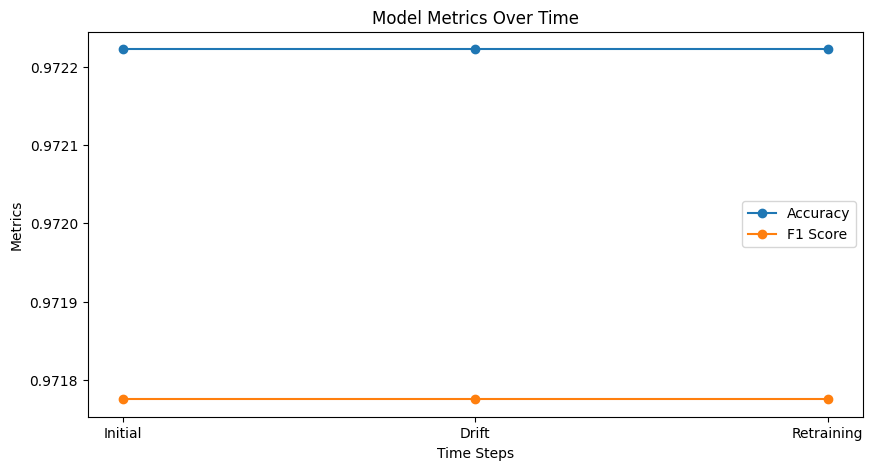

In [ ]:
# Evaluate the retrained model
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new, average='weighted')

# Example metrics log for visualization
time_steps = ["Initial", "Drift", "Retraining"]
accuracies = [accuracy, accuracy, accuracy_new]
f1_scores = [f1, f1, f1_new]

# Plot metrics
plt.figure(figsize=(10, 5))
plt.plot(time_steps, accuracies, label="Accuracy", marker="o")
plt.plot(time_steps, f1_scores, label="F1 Score", marker="o")
plt.title("Model Metrics Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Metrics")
plt.legend()
plt.show()

### Questions:
1. Observe the plot trends for accuracy and F1 score. How does data drift affect these metrics?
2. Why might retraining not always lead to improved metrics?

### Step 7: Log Events in MLFlow and View Model History

In [ ]:
# Initialize the MLFlow client
client = MlflowClient()

# Retrieve runs from the experiment
experiment_name = "mlops_exercise"
experiment = client.get_experiment_by_name(experiment_name)
if experiment:
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])
    print(f"Found {len(runs)} runs in the experiment '{experiment_name}':\n")
    for run in runs:
        print(f"Run ID: {run.info.run_id}")
        print(f"Metrics: {run.data.metrics}")
        print(f"Parameters: {run.data.params}")
        print("-" * 40)
else:
    print(f"No experiment found with the name '{experiment_name}'.")

Found 3 runs in the experiment 'mlops_exercise':

Run ID: 94e486f8c5364265ac94df97f06cb53d
Metrics: {'accuracy': 1.0, 'f1_score': 1.0}
Parameters: {}
----------------------------------------
Run ID: 15f6616cd4294cc09c5eec0e77a77fe5
Metrics: {'accuracy': 0.7777777777777778, 'f1_score': 0.7756036556036556}
Parameters: {}
----------------------------------------
Run ID: 76726b3cdacc41b685f6806d5f7042de
Metrics: {'accuracy': 1.0, 'f1_score': 1.0}
Parameters: {}
----------------------------------------
